In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

## Configure TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [4]:
path = "../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

In [5]:
img_height= img_width = 224
batch_size= 10
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(train_ds.class_names)

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


"\nfig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})\nfor i,ax in enumerate(axes.flat):\n    ax.imshow(plt.imread(dataset.path[i]))\n    ax.set_title(dataset.label[i])\n     \n"

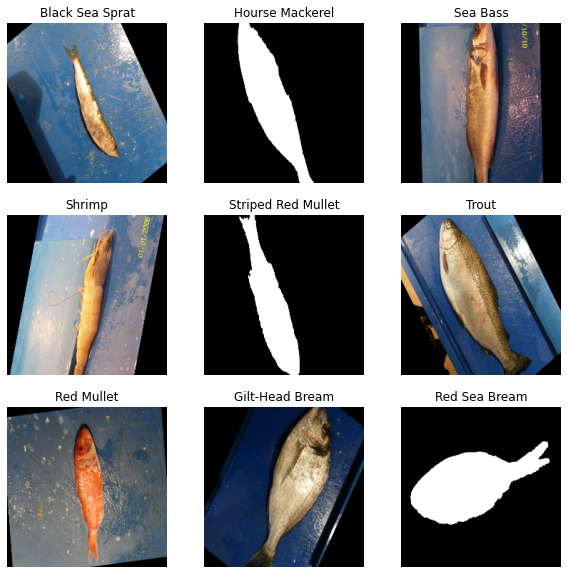

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
"""
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})
for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset.path[i]))
    ax.set_title(dataset.label[i])
     
"""

The values of the RGB channel are in the range [0, 255]. It is not ideal for a neural network
The normalisation layer will take this in charge

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Model creation

In [12]:

model = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

## Train model

In [14]:
epochs=4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
1440/1440 [==============================] - 305s 207ms/step - loss: 1.3588 - accuracy: 0.5063 - val_loss: 0.5735 - val_accuracy: 0.7828
Epoch 2/4
1440/1440 [==============================] - 111s 77ms/step - loss: 0.4687 - accuracy: 0.8340 - val_loss: 0.5685 - val_accuracy: 0.8158
Epoch 3/4
1440/1440 [==============================] - 109s 75ms/step - loss: 0.2103 - accuracy: 0.9258 - val_loss: 0.6476 - val_accuracy: 0.8225
Epoch 4/4
1440/1440 [==============================] - 106s 74ms/step - loss: 0.0933 - accuracy: 0.9677 - val_loss: 0.6957 - val_accuracy: 0.8294


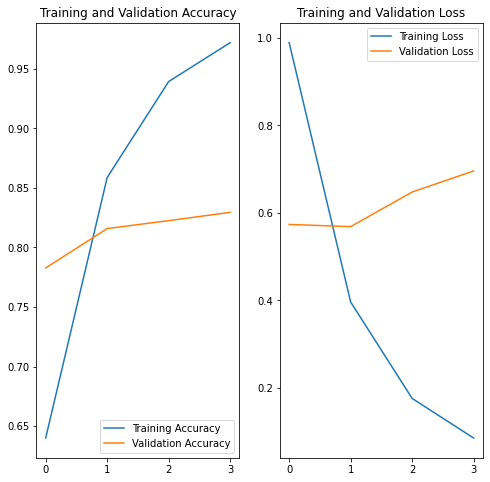

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()